# Make taxon-trait correlation bubble plot

The goal of this script is to generate a slightly unusual bubble plot. The plot will have the dominant taxa in coral microbiomes on one axis, and coral compartments (all, mucus, tissue, skeleton) on the other. The size of each bubble will be proportional to the R^2 value of that taxon's relative abundance correlated against a host trait in PGLS analysis.

## Check that necessary files are present

Before we start, let's check that necessary data files are present

In [1]:
from os.path import join
from os import listdir

data_folder = join("..","output","alpha_diversity_taxa")
file_list = listdir(data_folder)
print(file_list)
pgls_result_file = 'GCMP_dominant_taxa_vs_disease_susceptibility_compartments_pgls.csv'
#pgls_result_file = 'GCMP_taxa_alpha_diversity_all_pic.csv'
required_files = [pgls_result_file]

for rf in required_files:
    if rf not in file_list:
        raise IOError(f"Required data file {rf} ... could not be found in data folder {data_folder}. Existing files are {file_list}")
    else:
        print(f"Required data file {rf} ... OK")

['GCMP_dominant_taxa_vs_disease_susceptibility_compartments_pgls.csv', 'GCMP_taxa_alpha_diversity_all_pic.csv', 'GCMP_taxa_alpha_diversity_compartments_pgls.csv', 'GCMP_taxa_alpha_diversity_all_pgls.csv']
Required data file GCMP_dominant_taxa_vs_disease_susceptibility_compartments_pgls.csv ... OK


## Load PGLS data in pandas

We will next load the PGLS data in pandas. Multiple models of evolution were tested, so we need to be careful to select only the model with the lowest AICc score for plotting. The organization of the table will be more clear once we load it up.

In [2]:
import pandas as pd

pgls_df = pd.read_csv(join(data_folder, pgls_result_file))

#Take PIC only
pgls_df = pgls_df[pgls_df['Best_model'] == 'yes']

## Find unique dominant taxa

We want to loop over all dominant taxa, so we first need to identify them.

In [3]:
unique_taxa = list(pgls_df['Taxa_String'].unique())
print(f"Unique dominant taxa (n = {len(unique_taxa)}): {unique_taxa}")

Unique dominant taxa (n = 62): ['tissue_D_0__Archaea___D_1__Thaumarchaeota___D_2__Nitrososphaeria___D_3__Nitrosopumilales___D_4__Nitrosopumilaceae___D_5__Candidatus_Nitrosopumilus', 'tissue_D_0__Archaea___D_1__Thaumarchaeota___D_2__Nitrososphaeria___D_3__Nitrosopumilales___D_4__Nitrosopumilaceae___D_5__uncultured_archaeon', 'tissue_D_0__Bacteria___D_1__Bacteroidetes___D_2__Bacteroidia___D_3__Bacteroidales___D_4__Rikenellaceae___D_5__Rikenellaceae_RC9_gut_group', 'tissue_D_0__Bacteria___D_1__Bacteroidetes___D_2__Bacteroidia___D_3__Flavobacteriales___D_4__Flavobacteriaceae___D_5__Maritimimonas', 'tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Alphaproteobacteria___D_3__Rhizobiales___D_4__Beijerinckiaceae___D_5__Methylobacterium', 'tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Alphaproteobacteria___D_3__Rhodospirillales___D_4__Terasakiellaceae___D_5__uncultured', 'tissue_D_0__Bacteria___D_1__Proteobacteria___D_2__Alphaproteobacteria___D_3__Rickettsiales___D_4__Midichloriaceae___D_5

## Loop over compartments and taxa 

For each we want to look up the R2 value for the correlation between that microbe and disease, according to the best evolutionary model tested, which we will determined by comparing AICc score.

In [4]:
compartments = ['all','mucus','tissue','skeleton']
compartment_results_dict = {}
for compartment in compartments:
    
    #Set up an inner dict to hold per-organism results
    compartment_results_dict[compartment] = {}
    
    #Filter df to just the current compartment
    curr_pgls_df = pgls_df[pgls_df['Compartment'] == compartment]
    
    for unique_taxon in unique_taxa:
        #print(unique_taxon)
        taxon_pgls_df = curr_pgls_df[curr_pgls_df['Taxa_String'] == unique_taxon]
        
        if taxon_pgls_df.empty:
            continue
        
        taxon_pgls_df = taxon_pgls_df.sort_values('AICc')
        print(list(taxon_pgls_df['AICc']))
        best_model = taxon_pgls_df.iloc[0,:]
        print(dict(best_model))
        Rsquared = best_model['R_Squared']
        compartment_results_dict[compartment][unique_taxon.split("_",1)[1]] = dict(best_model)

results = pd.DataFrame(compartment_results_dict)

[258.3182281]
{'Disease_Trait': 'perc_dis', 'Taxa_String': 'all_D_0__Archaea___D_1__Thaumarchaeota___D_2__Nitrososphaeria___D_3__Nitrosopumilales___D_4__Nitrosopumilaceae___D_5__Candidatus_Nitrosopumilus', 'N_Unique_Sample': 42, 'Taxa': 'Nitrosopumilus', 'N_Microbes': 463791, 'Compartment': 'all', 'Package': 'caper', 'Model': 'pgls(x_trait~y_trait, data=comp.data, lambda=ML,kappa=1,delta=1)', 'pVal': 0.523070897, 'R_Squared': 0.009778395, 'Adj_R_Squared': -0.023111235, 'x_Trait_Slope_95CI': '3.899830522', 'Intercept_95CI': '3.37046272533332 + 2.77961460896784 - -1.14038539103216', 'Parameters': 'lambda=ML,delta=1,kappa=1', 'Estimated_Parameter_95CI': '1e-06 -/+ 0.241496627631281', 'AIC': 258.0255451, 'AICc': 258.3182281, 'Minimum_AIC': 'model_l', 'Minimum_AICc': 'model_l', 'Best_model': 'yes'}
[258.2330936]
{'Disease_Trait': 'perc_dis', 'Taxa_String': 'all_D_0__Bacteria___D_1__Bacteroidetes___D_2__Bacteroidia___D_3__Bacteroidales___D_4__Rikenellaceae___D_5__Rikenellaceae_RC9_gut_group'

## Make a bubble plot of R2 vs microbe

In [11]:
import numpy as np



unique_taxa_names = list(set([t.split("_",1)[1] for t in unique_taxa]))

x_position_mapping = {t:i for i,t in enumerate(sorted(unique_taxa_names))}
y_position_mapping = {'all':1.5,'mucus':1.0,'tissue':0.5,'skeleton':0}

color_mapping = {'all':'black','mucus':'cyan','tissue':'orange','skeleton':'purple'}
ytick_scalar = 0.01
x_values = []
y_values = []
sizes    = []
labels   = []
colors   = []
sig = []

#Exclude taxa not found in at least min_samples samples
min_samples = 5

#Multiply all sizes by a scalar
scaling_factor = 500

for unique_taxon_name in sorted(unique_taxa_names):
    labels.append(unique_taxon_name)
    
    for compartment in ['all','mucus','tissue','skeleton']:
        if unique_taxon_name not in compartment_results_dict[compartment].keys():
            continue
            
        result = compartment_results_dict[compartment][unique_taxon_name]['R_Squared']
        
        if not result or np.isnan(result) or str(result) == 'nan':
            continue
        
        n_samples = compartment_results_dict[compartment][unique_taxon_name]['N_Unique_Sample'] 
        
        
        pval = compartment_results_dict[compartment][unique_taxon_name]['pVal']
        
        
        if float(pval)  < 0.05: 
            colors.append(color_mapping[compartment])
            print(f"{unique_taxon_name} in {compartment}")
            print("N samples:",n_samples)
            print('Pval:',pval)
            print('R2:',result)
        else:
            colors.append('whitesmoke')
        x_value = x_position_mapping[unique_taxon_name]
        x_values.append(x_value)
        y_values.append(y_position_mapping[compartment]*ytick_scalar)
        sizes.append(result*scaling_factor)   
        sig.append(compartment_results_dict[compartment][unique_taxon_name]['pVal'])
            
  

D_0__Bacteria___D_1__Actinobacteria___D_2__Actinobacteria___D_3__Micrococcales___D_4__Promicromonosporaceae___D_5__Cellulosimicrobium in skeleton
N samples: 4
Pval: 0.001611855
R2: 0.22253335
D_0__Bacteria___D_1__Firmicutes___D_2__Clostridia___D_3__Clostridiales___D_4__Clostridiaceae_4___D_5__Paramaledivibacter in skeleton
N samples: 32
Pval: 0.018533537
R2: 0.130944066
D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas in all
N samples: 44
Pval: 0.000226443
R2: 0.279296974
D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas in mucus
N samples: 35
Pval: 4.79e-06
R2: 0.427334441
D_0__Bacteria___D_1__Proteobacteria___D_2__Gammaproteobacteria___D_3__Oceanospirillales___D_4__Endozoicomonadaceae___D_5__Endozoicomonas in tissue
N samples: 38
Pval: 0.000240218
R2: 0.301960047


## Make the actual Bubble plot

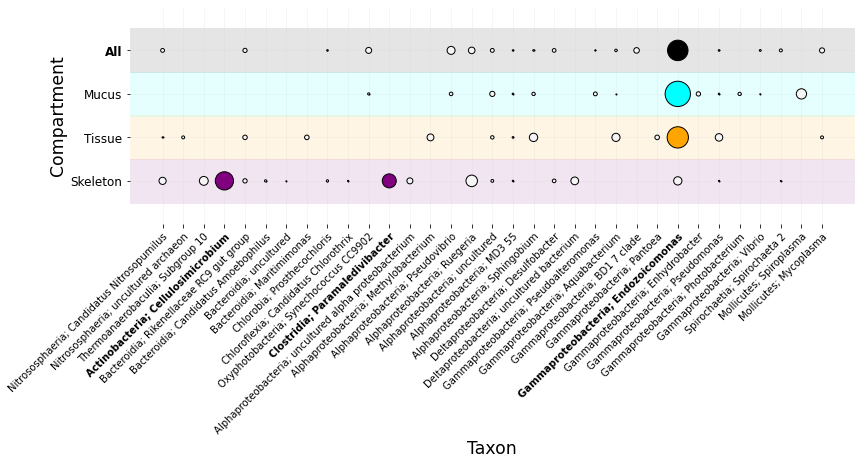

In [10]:
import matplotlib.pyplot as plt
from  numpy import array

fig,ax = plt.subplots(figsize=(13,4))

ax.scatter(x_values,y_values,s=1,facecolor='k',edgecolor='k',alpha=1.0)
ax.scatter(x_values,y_values,s=array(sizes)*3,c=colors,edgecolors='k',alpha=1.0)

for compartment in compartments:
    ax.axhline(y_position_mapping[compartment]*ytick_scalar,\
      color=color_mapping[compartment],alpha=0.10,linewidth=45,zorder=0)

#Set the custom x and y-axis labels to make this a bubble plot
ax.set_yticks([i*ytick_scalar*0.5 for i in range(len(compartments))])
ax.set_yticklabels([c.capitalize() for c in reversed(compartments)],size='large')

ax.set_xticks([i for i in range(len(labels))])

def format_xtick_labels(full_taxon_strings):
    result = []
    for t in full_taxon_strings:
        fields = t.split("__")
        name = fields[-7]+"; "+fields[-1]
        name = name.replace("_"," ")
        result.append(name)
        #result.append(fields[-1])
    return result


ax.set_xticklabels([l for l in format_xtick_labels(labels)],size='medium',\
                   rotation = 45, ha = "right",rotation_mode="anchor")


xtick_labels = format_xtick_labels(labels)
ax.set_axisbelow(True)
unique_x_values = list(range(len(labels)))

margin = 0.005
ax.set_ylim(min(y_values)-margin,max(y_values)+margin)
ax.set_ylabel('Compartment',size = 'xx-large')
ax.set_xlabel('Taxon',size = 'xx-large')
ax.grid(color='lightgrey',alpha=0.25)

#Special formatting for some labels
for label in (ax.get_xticklabels()):
    if "Endozoicomonas" in str(label) or "Cellulosimicrobium" in str(label) or "Paramaledivibacter" in str(label):
        label.set_weight("heavy")    

for label in (ax.get_yticklabels()):
    if "All" in str(label):
        label.set_weight("heavy") 
        label.set_color("k")
      
## Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig("../output/taxon_bubble_plot.pdf")
fig.savefig("../output/taxon_bubble_plot.png")